# 2022-02-21 • FENS 2022 Abstract

As usual, the reusable code of the previous notebook 
has been added in [`pkg/VoltageToMap/src/`](https://github.com/tfiers/voltage-to-wiring-sim/tree/main/pkg/VoltageToMap/src),
and is imported below.

## Setup

In [1]:
# 

In [2]:
using Revise  # Reloads src code without having to restart kernel

In [3]:
using MyToolbox

In [4]:
using VoltageToMap

[ Info: Precompiling VoltageToMap [b3b8fdc5-3c26-4000-a0c8-f17415fdf48e]


## Params & sim

Short warm-up run. Get compilation out of the way.

In [22]:
p0 = ExperimentParams(sim=SimParams(inputs=previous_N_30_inputs, duration=1 * minutes));

In [23]:
@time sim(p0.sim);

  2.311696 seconds (1.21 M allocations: 169.872 MiB, 91.71% gc time)


In [38]:
p = ExperimentParams(
    sim = SimParams(
        inputs = realistic_N_6600_inputs,
        duration = 10 * minutes,
        synapses = SynapseParams(Δg_multiplier = 0.066),
    )
)
dumpc(p)

ExperimentParams
  seed: 22022022
  sim: SimParams
    duration: 600.0
    Δt: 0.0001
    num_timesteps: 6000000
    seed: 0
    inputs: PoissonInputsParams
      N_unconn: 100
      N_exc: 5200
      N_inh: 1300
      N_conn: 6500
      N: 6600
      spike_rates: LogNormal
        μ: 1.08629
        σ: 0.774597
    synapses: SynapseParams
      Δg_exc: 4.0e-10
      Δg_inh: 1.6e-9
      Δg_multiplier: 0.066
      E_exc: 0.0
      E_inh: -0.065
      g_t0: 0.0
      τ: 0.007
    izh_neuron: IzhikevichParams
      C: 1.0e-10
      k: 7.0e-7
      v_rest: -0.06
      v_thr: -0.04
      a: 30.0
      b: -2.0e-9
      v_peak: 0.035
      v_reset: -0.05
      Δu: 1.0e-10
      v_t0: -0.06
      u_t0: 0.0
    imaging: VoltageImagingParams
      spike_SNR: 10.0
      spike_SNR_dB: 20.0
      spike_height: 0.095
      σ_noise: 0.0095
  conntest: ConnTestParams
    STA_window_length: 0.1
    num_shuffles: 100
    seed: 22022022
  evaluation: EvaluationParams
    num_tested_neurons_per_group: 40

In [39]:
t, v, input_spikes = @time sim(p.sim);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:39
159.438690 seconds (18.23 M allocations: 2.165 GiB, 10.06% gc time, 0.01% compilation time)


In [41]:
num_spikes = length.(input_spikes)

ComponentVector{Int64}(conn = (exc = [1228, 940, 1389, 948, 509, 997, 831, 527, 1041, 876  …  1059, 997, 1200, 1103, 350, 585, 1106, 386, 1203, 798], inh = [470, 979, 876, 183, 882, 746, 1152, 1032, 201, 661  …  1287, 677, 865, 576, 1076, 1185, 1101, 1065, 927, 1334]), unconn = [908, 983, 717, 1052, 1400, 946, 680, 1444, 759, 612  …  1435, 868, 854, 329, 1235, 1300, 1394, 725, 505, 390])

## Plot

In [92]:
using Sciplotlib

In [43]:
""" tzoom = [200ms, 600ms] e.g. """
function plotsig(t, sig, tzoom = nothing; ax = nothing, clip_on=false, kw...)
    isnothing(tzoom) && (tzoom = t[[1, end]])
    izoom = first(tzoom) .≤ t .≤ last(tzoom)
    if isnothing(ax)
        plot(t[izoom], sig[izoom]; clip_on, kw...)
    else
        plot(t[izoom], sig[izoom], ax; clip_on, kw...)
    end
end;

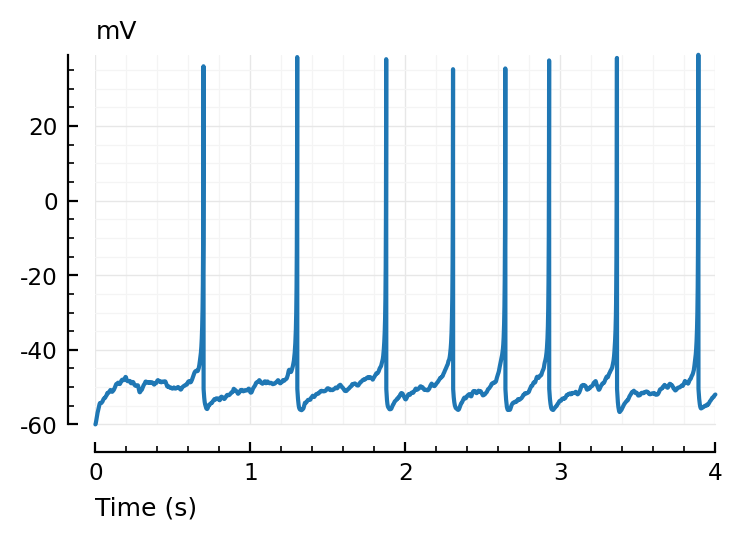

In [44]:
plotsig(t, v/mV, [0s, 4seconds], xlabel="Time (s)", hylabel="mV");

## Imaging noise

In [45]:
resetrng!(p.sim.seed)
noise = randn(length(v)) * p.sim.imaging.σ_noise
vimsig = v + noise;

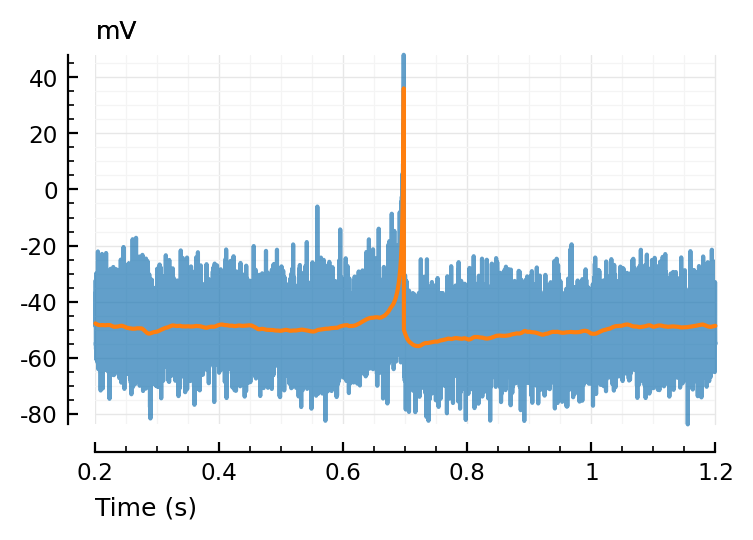

In [46]:
ax = plotsig(t, vimsig / mV, [200ms,1200ms], xlabel="Time (s)", hylabel="mV", alpha=0.7);
plotsig(t, v / mV, [200ms,1200ms], xlabel="Time (s)", hylabel="mV"; ax);

## Window

In [47]:
const window_length = p.conntest.STA_window_length
const Δt = p.sim.Δt
const win_size = round(Int, window_length / Δt)
const t_win = linspace(zero(window_length), window_length, win_size)  # for plottin

function calc_STA(presynaptic_spikes)
    STA = zeros(eltype(vimsig), win_size)
    win_starts = round.(Int, presynaptic_spikes / Δt)
    num_wins = 0
    for a in win_starts
        b = a + win_size - 1
        if b ≤ lastindex(vimsig)
            STA .+= @view vimsig[a:b]
            num_wins += 1
        end
    end
    STA ./= num_wins
    return STA
end;

In [48]:
function plotSTA(presynspikes)
    STA = calc_STA(presynspikes)
    plot(t_win/ms, STA/mV)
end;

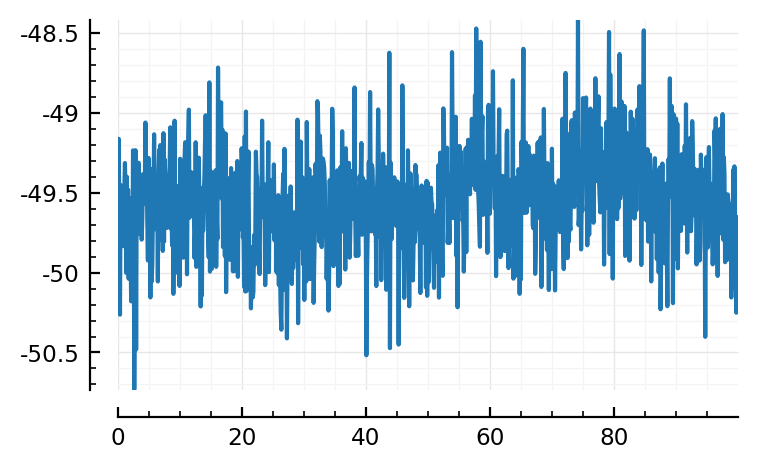

In [78]:
example_presynspikes = rand(input_spikes.conn.exc)
plotSTA(example_presynspikes);

## Test connection

In [79]:
to_ISIs(spiketimes) = [first(spiketimes); diff(spiketimes)]  # copying
to_spiketimes!(ISIs) = cumsum!(ISIs, ISIs)                   # in place

(example_presynspikes |> to_ISIs |> to_spiketimes!) ≈ example_presynspikes   # test

true

In [80]:
shuffle_ISIs(spiketimes) = to_spiketimes!(shuffle!(to_ISIs(spiketimes)));

In [81]:
test_statistic(spiketimes) = spiketimes |> calc_STA |> mean;

Note difference with 2021: there it was peak-to-peak (max - min). Here it is mean.

In [89]:
const num_shuffles = p.conntest.num_shuffles

function test_connection(presynspikes)
    real_t = test_statistic(presynspikes)
    shuffled_t = Vector{typeof(real_t)}(undef, num_shuffles)
    resetrng!(p.conntest.seed)
    for i in eachindex(shuffled_t)
        shuffled_t[i] = test_statistic(shuffle_ISIs(presynspikes))
    end
    N_shuffled_larger = count(shuffled_t .> real_t)
    return if N_shuffled_larger == 0
        p_value = 1 / num_shuffles
    else
        p_value = N_shuffled_larger / num_shuffles
    end
end;

## Results

In [ ]:
p_exc

In [143]:
num_trains = p.evaluation.num_tested_neurons_per_group
num_trains = 300

resetrng!(p.evaluation.seed)
tested_spike_trains_exc = rand(input_spikes.conn.exc, num_trains)
tested_spike_trains_inh = rand(input_spikes.conn.inh, num_trains)
tested_spike_trains_unconn = rand(input_spikes.unconn, min(num_trains, 100))

p_exc    = Float64[]
p_inh    = Float64[]
p_unconn = Float64[]

for (groupname, spiketrains, pvals) in (
        ("excitatory",    tested_spike_trains_exc,    p_exc),
        ("inhibitory",    tested_spike_trains_inh,    p_inh),
        ("unconnected",   tested_spike_trains_unconn, p_unconn),
    )
    @showprogress 200ms groupname for spiketrain in spiketrains
        push!(pvals, test_connection(spiketrain))
    end
end

excitatory100%|█████████████████████████████████████████| Time: 0:01:38
inhibitory100%|█████████████████████████████████████████| Time: 0:01:30
unconnected100%|████████████████████████████████████████| Time: 0:00:33


In [144]:
best_exc = tested_spike_trains_exc[p_exc .== minimum(p_exc)]
best_inh = tested_spike_trains_inh[p_inh .== maximum(p_inh)]
length(best_exc), length(best_inh)

(8, 19)

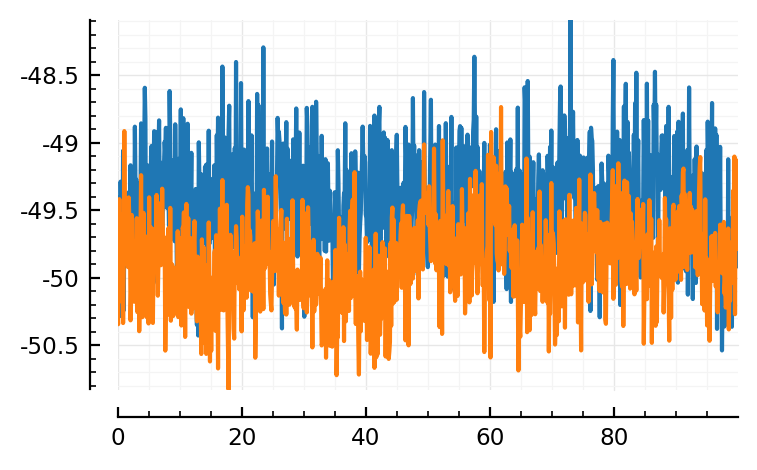

(2, 9)

In [173]:
st_exc_i, st_exc = rand(pairs(best_exc))
st_inh_i, st_inh = rand(pairs(best_inh))
plotSTA(st_exc)
plotSTA(st_inh)
st_exc_i, st_inh_i

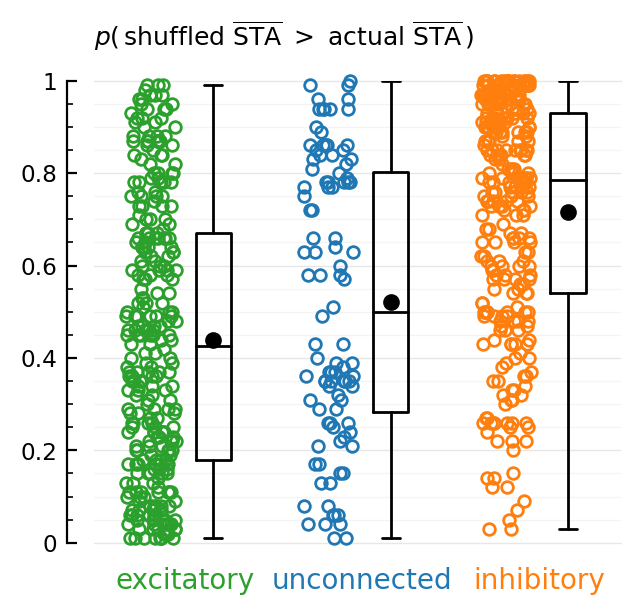

In [140]:
fig, ax = plt.subplots(figsize=(3.4,3))
function plotdot(y, x, c, jitter=0.28)
    N = length(y)
    x -= 0.35
    plot(x*ones(N) + (rand(N).-0.5)*jitter, y, "o", color=c, ms=4.2, markerfacecolor="none", clip_on=false)
    plot(x+0.35, mean(y), "k.", ms=10)
end
plotdot(p_exc,    1, "C2"); ax.text(1-0.16, -0.1, "excitatory"; color="C2", ha="center")
plotdot(p_unconn, 2, "C0"); ax.text(2-0.16, -0.1, "unconnected"; color="C0", ha="center")
plotdot(p_inh,    3, "C1"); ax.text(3-0.16, -0.1, "inhibitory"; color="C1", ha="center")
ax.boxplot([p_exc, p_unconn, p_inh], widths=0.2, medianprops=Dict("color"=>"black"))
Sciplotlib.set(ax, xlim=(0.33, 3.3), ylim=(0, 1), xaxis=:off)
hylabel(ax, L"p(\, \mathrm{shuffled\ \overline{STA}} \ > \ \mathrm{actual\ \overline{STA}}\, )"; dy=10);